#### ISYE 6740 - Machine Learning

Homework 4 - Graham Billey

### **1) Implementing the EM algorithm on the MNIST dataset.**

Implement the EM algorithm for fitting a Gaussian mixture model for the MNIST dataset. We reduce
the dataset to be only two cases, of digits $2$ and $6$ only. Thus, you will fit GMM with `C = 2`. Use
the data file `data.mat` or `data.dat` on Canvas. True label of the data are also provided in `label.mat` and
`label.dat`

The matrix images is of size $784$-by-$1990$, i.e., there are totally 1990 images, and each column of the
matrix corresponds to one image of size $28$-by-$28$ pixels (the image is vectorized; the original image
can be recovered by map the vector into a matrix.)

Hint: You may find the notes `speed-up-GMM.pdf` useful, which explains how to evaluate the density of
a multi-variate normal distribution. In this homework question, it is recommended you implement the
evaluation of the Gaussian density this way, to avoid numerical issues.

**a) Select from data one raw image of $2$ and $6$ and visualize them, respectively.**

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import multivariate_normal as mvn

data = loadmat('data.mat')['data'].T
images, dimensions = data.shape

labels = loadmat('label.mat')['trueLabel'].T

Two handwritten digits from the MNIST dataset.


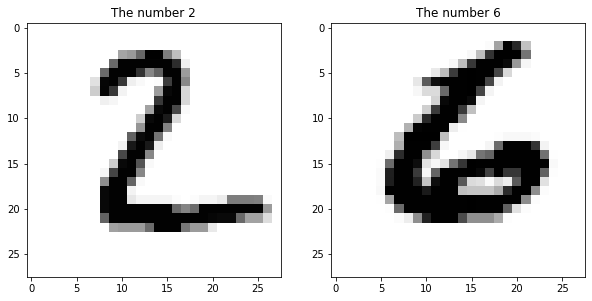

In [2]:
examples = [0, -1]
numbers = [2, 6]
fig = plt.figure(figsize=(10,10))
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(f'The number {numbers[i]}')
    imgplot = ax.imshow(np.reshape(data[examples[i]], (28,28), order='F'), cmap='Greys')
    
print('Two handwritten digits from the MNIST dataset.')
plt.show()

**b) Use random Gaussian vector with zero mean as random initial means, and two identity matrices I as initial covariance matrices for the clusters. Plot the log-likelihood function versus the number of iterations to show your algorithm is  converging.**

In [3]:
def fast_gaussian_pdf(x, mu, sigma, r):
    n, m = x.shape

    # Compute the eigendecomposition of sigma, in DESCENDING order of eigenvalues
    eVals, eVecs = np.linalg.eig(sigma)
    idx = eVals.argsort()[::-1]   
    eVals = eVals[idx]
    eVecs = eVecs[:,idx]

    # Compute the low-rank approximation of sigma
    U_hat = eVecs[:,0:r]
    Lambda_hat = np.diag(eVals[0:r])
    Sigma_hat = U_hat @ Lambda_hat @ U_hat.T

    # Compute the transformation of the data and parameters
    data_hat = (U_hat.T @ data.T).T
    mu_hat = (U_hat.T @ mu)

    # Compute the log-likelihood of the density
#     minus_log_A = -0.5 * (m*np.log(2*np.pi) + np.sum(np.log(eVals[0:r])))
    minus_log_A = -0.5 * (np.sum(np.log(eVals[0:r])))      # Removing the -m*np.log(2*np.pi) due to numerical issues
    B = -1/2*np.sum((data_hat-mu_hat)**2/eVals[0:r],axis=1)

    log_lik = minus_log_A + B
    
    # Return the actual likelihood
    return np.exp(log_lik)
    

In [4]:
def initialize_EM(k, data):
    ''' k is the number of Gaussians '''
    m, d = data.shape
    
    pis = np.ones(k)/sum(np.ones(k))
    mus = []
    sigmas = []
    
    for i in range(k):
        mus.append(mvn.rvs(mean=np.zeros(d)))
        sigmas.append(np.identity(d))
        
    mus = np.stack(mus)
    sigmas = np.stack(sigmas)
    
    return mus, pis, sigmas

In [11]:
def Gaussian_EM(data, k, r, max_iter=10):
    ''' k is the number of Gaussians to fit.
        r is the number of dimensions to use when approximating the Gaussian pdf. '''
    
    print('Running Guassian_EM...')

    m, d = data.shape
    log_lik = []
    t0=time.time()
    
    ###### Initialize the mus, pis, and sigmas parameters ######
    mus, pis, sigmas = initialize_EM(k, data)
    
    ##### Iterate through the E-M algorithm #####
    for itn in range(max_iter):
#         print(f'Beginning EM Iteration {itn+1}...')
            
        ###### Expectation Step ######
        taus = np.zeros(shape=(m, k))
        for c in range(k):
            probs = fast_gaussian_pdf(data, mus[c], sigmas[c], r)
            taus[:,c] = probs

        taus = taus*pis
        log_lik.append(np.sum(np.log(np.sum(taus, axis=1))))
        taus /= taus.sum(axis=1)[:,None]

        ###### Maximization Step ######
        mus = ((taus.T @ data).T/np.sum(taus, axis=0)).T
        pis = np.sum(taus, axis=0)/m
        
        sigmas = np.zeros(shape=(k,d,d))
        for c in range(k):     # clusters
            for i in range(m): # datapoints
                tau_ik = taus[i,c]
                vec = data[i,:] - mus[c,:]
                sigmas[c,:,:] += np.outer(vec, vec)*tau_ik
            sigmas[c,:,:] /= np.sum(taus, axis=0)[c]

    print(f'Gaussian EM has finished running in {round(time.time() - t0,0)} seconds.')
    return pis, mus, sigmas, taus, log_lik, itn    
            

In [12]:
import warnings
warnings.filterwarnings('ignore')

p, m, s, t, ll, it = Gaussian_EM(data, k=2, r=15, max_iter=50)

Running Guassian_EM...
Gaussian EM has finished running in 942.0 seconds.


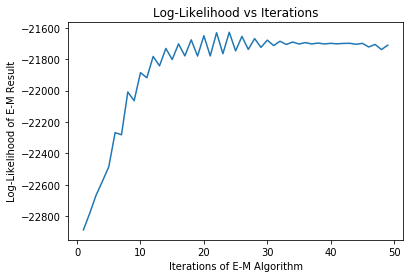

In [13]:
plt.plot(range(1,len(ll)),ll[1:])
plt.title('Log-Likelihood vs Iterations')
plt.xlabel('Iterations of E-M Algorithm')
plt.ylabel('Log-Likelihood of E-M Result')
plt.show()

From the plot above we can see the algorithm approach its limit at around 15 iterations. There is some cyclical behavior around the limit, likely due to the simplified calculation of the Log-Likelihood in the  `fast_gaussian_pdf()` function.

**c) Report, the fitting GMM model when EM has terminated in your algorithms, including the weights for each component and the mean vectors (please reformat the vectors into $28$-$28$ images. Ideally, you should be able to see these means correcponds to "average" images. No need to report the covariance matrices.**

Two handwritten digits from the MNIST dataset.


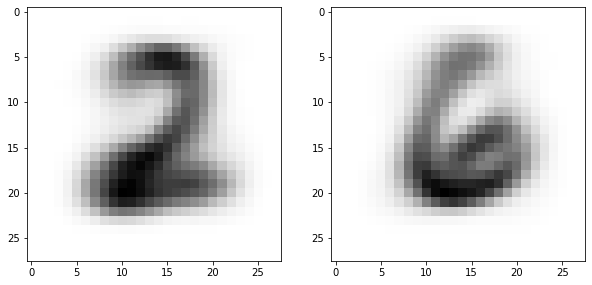

In [14]:
fig = plt.figure(figsize=(10,10))
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
#     ax.set_title(f'The number {numbers[i]}')
    imgplot = ax.imshow(np.reshape(m[i], (28,28), order='F'), cmap='Greys')
    
print('Two handwritten digits from the MNIST dataset.')
plt.show()

In [37]:
print(f'The weights for each cluster are: {p}')

The weights for each cluster are: [0.4367032 0.5632968]


**d) Use the $p_ic$ to infer the labels of the images, and compare with the true albels. Report the misclassification rate for digits "2" and "6", respectively. Perform K-means clustering with K=2. Find out the misclassificatin rate for sigits "2" and "6", respectively, and compare with your GMM. Which one achieves better performance?**

In [38]:
# Predict the labels for each datapoint
t_rounded = np.round(t)
t_rounded[:,0] = t_rounded[:,0]*2
t_rounded[:,1] = t_rounded[:,1]*6
pred_labels = np.sum(t_rounded, axis=1)
pred_labels = pred_labels.reshape((1990, 1))

In [80]:
# Calculate prediction accuracy for data labeled 2 and 6

pred2 = set(np.where(pred_labels==2)[0])
print(f'We predicted {len(pred2)} digits to be number 2 \n')
act2 = set(np.where(labels==2)[0])
print(f'There are actually {len(act2)} digits that are number 2 \n')
print(f'We accurately categorized {len(pred2&act2)} of the "2" digits, and incorrectly labeled {len(pred2-act2)} digits as "2" \n')
print(f'Our accuracy labeling "2" digits is {round(len(pred2&act2)/len(pred2)*100,2)}% \n')

print('---------------------------------')

pred6 = set(np.where(pred_labels==6)[0])
print(f'We predicted {len(pred6)} digits to be number 6 \n')
act6 = set(np.where(labels==6)[0])
print(f'There are actually {len(act6)} digits that are number 6 \n')
print(f'We accurately categorized {len(pred6&act6)} of the "6" digits, and incorrectly labeled {len(pred6-act6)} digits as "6" \n')
print(f'Our accuracy labeling "6" digits is {round(len(pred6&act6)/len(pred6)*100,2)}% \n')


We predicted 846 digits to be number 2 

There are actually 1032 digits that are number 2 

We accurately categorized 695 of the "2" digits, and incorrectly labeled 151 digits as "2" 

Our accuracy labeling "2" digits is 82.15% 

---------------------------------
We predicted 1144 digits to be number 6 

There are actually 958 digits that are number 6 

We accurately categorized 807 of the "6" digits, and incorrectly labeled 337 digits as "6" 

Our accuracy labeling "6" digits is 70.54% 



In [81]:
from sklearn.cluster import KMeans

In [104]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)
t0=time.time()
kmeans.labels_
print(f'K-means ran in {time.time() - t0} seconds \n')

pred2_k = set(np.where(kmeans.labels_==0)[0])
print(f'K-means predicted {len(pred2_k)} digits to be number 2 \n')
print(f'There are actually {len(act2)} digits that are number 2 \n')
print(f'K-means accurately categorized {len(pred2_k&act2)} of the "2" digits, and incorrectly labeled {len(pred2_k-act2)} digits as "2" \n')
print(f'K-means accuracy labeling "2" digits is {round(len(pred2_k&act2)/len(pred2_k)*100,2)}% \n')

print('--------------------------------- \n')

pred6_k = set(np.where(kmeans.labels_==1)[0])
print(f'K-means predicted {len(pred6_k)} digits to be number 6 \n')
print(f'There are actually {len(act6)} digits that are number 6 \n')
print(f'K-means accurately categorized {len(pred6_k&act6)} of the "6" digits, and incorrectly labeled {len(pred6_k-act6)} digits as "6" \n')
print(f'K-means accuracy labeling "6" digits is {round(len(pred6_k&act6)/len(pred6_k)*100,2)}% \n')

K-means ran in 0.0 seconds 

K-means predicted 1044 digits to be number 2 

There are actually 1032 digits that are number 2 

K-means accurately categorized 976 of the "2" digits, and incorrectly labeled 68 digits as "2" 

K-means accuracy labeling "2" digits is 93.49% 

--------------------------------- 

K-means predicted 946 digits to be number 6 

There are actually 958 digits that are number 6 

K-means accurately categorized 890 of the "6" digits, and incorrectly labeled 56 digits as "6" 

K-means accuracy labeling "6" digits is 94.08% 



In [100]:
942/0.01

94200.0

In this case, K-Means was not only _**at least 90,000 times faster**_ than the EM algorithm (the generic `time.time()` function could not calculate the time K-Means took to run), but it was also much more accurate than the EM algorithm.

The prediction accuracy increased when using K-Means, from 82.2% to 93.5% (number 2) and from 70.5% to 94.1% (number 6).

This example did little to instill confidence in me that the EM algorithm is superior to other _**much simpler**_ algorithms, like K-Means.

-------------------

-------------------

### **2) Basic Optimization**

Consider a simplified logistic regression problem. Given $n$ training samples $(x_i, y_i), i = 1, ..., n$, the data $x_i \in \mathbb{R}, y \in {0, 1}$. To train/fit a logistic regression model for classification, we solve the following optimization problem, where $\theta \in \mathbb{R}$ is a parameter we aim to find: $$ \max_\theta l(\theta) $$.

Where the log-likelihood function is: $$ l(\theta) = \sum_{i=1}^n \{-log(1+e^{-\theta x_i}) + (y_i - 1)\theta x_i \} $$

**a) Derive the gradient of the cost function $l(\theta)$, and write pseudo-code for performing gradient descent to find the optimizer $\theta^*$.**

$ \large l(\theta) = \sum_{i=1}^n \{-log(1+e^{-\theta x_i}) + (y_i - 1)\theta x_i \}$

$ \large \quad\quad = \sum_{i=1}^n \{ y_i \theta x_i - \theta x_i  -log(1+e^{-\theta x_i}) \} $

Using the identity $ log(a) + log(b) = log(ab) $,

$ \large \quad\quad = \sum_{i=1}^n \{ y_i \theta x_i -log(1+e^{\theta x_i}) \} $

Now we take the derivative w.r.t. $\theta$...

$ \large \frac{\partial}{\partial \theta} \sum_{i=1}^n \{ y_i \theta x_i -log(1+e^{\theta x_i}) \} $

$ \large \quad\quad = \frac{\partial}{\partial \theta}  \sum_{i=1}^n\{ y_i \theta x_i \} - \frac{\partial}{\partial \theta}  \sum_{i=1}^n \{ log(1 + e^{\theta x_i}) \}$

$ \large \quad\quad = \sum_{i=1}^n \{ y_i x_i - \frac{x_i e^{\theta x_i}}{1 + e^{\theta x_i}} \} $

**Algorithm for performing gradient descent:**

> 1) Initialize $\theta$. In general you can pick a random initial value in the domain $\theta \in \mathbb{R}$.

> 2) Plug theta into the derivative shown above (using **all** data points) to calculate the slope of the log-likelihood function at that value of $\theta$.

> 3) Choose the direction that maximizes $l(\theta)$, or equivalently minimizes $- l(\theta)$. Since this problem only has one parameter, we will either be increasing or decreasing $\theta$.

> 4) Update $\theta$ by an amount proportional to the gradient. i.e. $\theta_{new} = \theta - \alpha \nabla$

> 5) Repeat steps 2 - 4 until a termination criterion is met. Either a predetermined number of iterations has occurred, or the change in the log-likelihood between consectuive steps is sufficiently small.

**b) Write down a stochastic gradient-descent algorithm to solve the training of the logistic regression problem.**

**Algorithm for performing _stochastic_ gradient descent:**

> 1) Initialize $\theta$. In general you can pick a random initial value in the domain $\theta \in \mathbb{R}$.

>> 2a) Randomly choose one data point to use to evaluate the gradient at that point.

>> 2b) Plug theta into the derivative shown above (using **the chosen** data point) to calculate the slope of the log-likelihood function at that value of $\theta$.

> 3) Choose the direction that maximizes $l(\theta)$, or equivalently minimizes $- l(\theta)$. Since this problem only has one parameter, we will either be increasing or decreasing $\theta$.

> 4) Update $\theta$ by an amount proportional to the gradient. i.e. $\theta_{new} = \theta - \alpha \nabla$

> 5) Repeat steps 2 - 4 until a termination criterion is met. Either a predetermined number of iterations has occurred, or the change in the log-likelihood between consectuive steps is sufficiently small.

**c) Show that the training problem in logistic regression is concave.** Derive the Hessian matrix of $l(\theta)$. Explain why the problem can be solved efficiently and gradient descent will achieve a unique global optimizer.

$ \large H = \frac{\partial^2}{\partial(\theta)^2} \,\, l(\theta) $

$ \large \quad\quad = \frac{\partial}{\partial(\theta)} \sum_{i=1}^n \{ y_i x_i - \frac{x_i e^{\theta x_i}}{1 + e^{\theta x_i}} \} $

$ \large \quad\quad = \sum_{i=1}^n \{ -\frac{x_i^2 e^{\theta x_i}}{(e^{\theta x_i} + 1)^2} \} $

Since $\large x_i, \theta \in \mathbb{R}$, $\large H \leq 0 \quad \forall x_i, \theta$. **Thus the log-likelihood $l(\theta)$ is concave.**

Because $l(\theta)$ is concave, we know that any local optimum is also a global optimum. With a reasonable learning rate, gradient descent always efficiently converges to a local optimum. **Thus it will always reach a global optimum.**